<h1>Validator for br2_act_LC {ActCons, ActGen} 2013-2025<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Используемые-ресурсы" data-toc-modified-id="Используемые-ресурсы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Используемые ресурсы</a></span></li><li><span><a href="#Препроцессинг-данных" data-toc-modified-id="Препроцессинг-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Препроцессинг данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Валидация-модели" data-toc-modified-id="Валидация-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Валидация модели</a></span></li><li><span><a href="#Расчёт-метрик-модели" data-toc-modified-id="Расчёт-метрик-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт метрик модели</a></span></li></ul></div>

# Используемые ресурсы

In [1]:
import os
import re
import locale
import requests
import warnings
import calendar
from bs4 import BeautifulSoup
from tqdm.notebook import trange

import notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from platform import python_version
import xgboost as xgb
import graphviz
from datetime import time
from datetime import datetime
from datetime import timedelta
import sklearn
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LearningCurveDisplay

# Глобальные гиперпараметры
period = 10
max_depth = 5
n_estimators = 200

print(f"python: v {python_version()}")
print(f"Jupyter Notebook: v {notebook.__version__}")
print(f"numpy: v {np.__version__}")
print(f"pandas: v {pd.__version__}")
print(f"seaborn: v {sns.__version__}")
print(f"graphviz: v {graphviz.__version__}")
print(f"matplotlib: v {matplotlib.__version__}")
print(f"sklearn: v {sklearn.__version__}")
print(f"XGBoost: v {xgb.__version__}")

python: v 3.10.7
Jupyter Notebook: v 6.4.12
numpy: v 1.25.2
pandas: v 2.2.3
seaborn: v 0.13.2
graphviz: v 0.20.1
matplotlib: v 3.6.2
sklearn: v 1.4.2
XGBoost: v 2.1.2


# Препроцессинг данных

Загрузка ранее подготовленной базы данных с последующей проверкой целостности её данных

In [2]:
df = pd.read_excel('DataBase.xlsx')

def is_check_DataBase(df):
    
    i, date, status = 0, df.iloc[0].Date, True
    
    while (date != df.iloc[-1].Date):
        if df.iloc[i].Date != date:
            status = False
            print("\033[1;31m{}".format(f'WARNING: no data on date {date}'))
        else:
            i += 1
        date += timedelta(hours=1)
    
    if df.isnull().any().any():
        status = False
        print('\033[1;31m{}'.format(f'WARNING: The database contains NULL:\n{df[df.isnull().any(axis=1)].Date}'))
        
    if status:
        print("\033[1;32m{}".format(f'The database is complete'))
        
    #return status
    
is_check_DataBase(df)

The database is complete


Создание глобальной переменной с БД, индексируемой по дате

In [3]:
df_general_date_index = df.set_index('Date')

Cоздание пустого датафрейма (25 строк: с 0:00 до 24:00) на указанную дату (для полноценной интерполяции температуры)

In [4]:
def get_empty_daily_df(date):
    return pd.DataFrame(pd.date_range(date, periods=25, freq='h'), columns=['Date'])
    
#get_empty_daily_df(datetime(2024,6,5))

Пополнение датафрейма дополнительными (временными) категориальными признаками

In [5]:
def add_date_scalar(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] =  df.Date.dt.day
    df['Hour'] = df.Date.dt.hour
    df['Hour'] = df['Hour']
    df['Weekday'] = df.Date.dt.weekday
    return df

#add_date_scalar(test_df)

Выгрузка архива погоды на указанную дату

In [6]:
def get_weather(date):
    # закоментить строчку при работе online (даёт незначительное искажение из-за масштабов интерполяции)
    #return get_empty_daily_df(date).merge(df_general_date_index.Temperature, how='left', on='Date').tail(24)
    
    months = ['', 'января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 
              'июля', 'августа', 'сентября', 'октября', 'ноября', 'декабря']  # названия месяцев в родительном падеже
            
    while True:  # повторяем запрос до тех пор, пока не получим положительный HTTP-ответ от сервера
        try:
            # выгружаем содержимое страницы https://kazan.nuipogoda.ru/ в переменную
            page = requests.get(url=f'https://kazan.nuipogoda.ru/{date.day}-{months[date.month]}#{date.year}', timeout=10)  # Добавили timeout
            page.raise_for_status()  # Проверяем на HTTP ошибки
            break
        except requests.exceptions.RequestException as error:  # Ловим все ошибки requests
            print(f'{error} for {date}')
            
    # сохраняем html-код страницы в переменную
    soup = BeautifulSoup(page.text, 'html.parser')

    # фильтруем теги с температурой
    trs = soup.find_all('tr', time=re.compile(r'[0-9]'))

    # получаем "сырые" данные
    day_weather_df = list()

    for tr in trs:
        day_weather_df.append((list(tr.attrs.values())[0], tr.find('span', class_='ht').text[:-1]))

    # формируем интерпретируемый датафрейм
    day_weather_df = pd.DataFrame(day_weather_df, columns=['Date', 'Temperature']).astype('int64')
    day_weather_df.Date = pd.to_datetime(day_weather_df.Date, unit='ms')
    
    if (date.day == 31 and date.month == 12):  # кастыль для перехода на следующий год
        day_weather_df = day_weather_df[((day_weather_df.Date.dt.year == date.year) &
                                        (day_weather_df.Date.dt.month == date.month)) | 
                                        (day_weather_df.Date == datetime.combine(date + timedelta(days=1), time(hour=0)))]
    else:
        day_weather_df = day_weather_df[day_weather_df.Date.dt.year == date.year]
    
    # интерполируем пропуски температуры (полиноминальная 3 порядка) между 0, 3, 6, 9, 12, 15, 18, 21 и 24 часами
    day_weather_df = get_empty_daily_df(date).merge(day_weather_df, how='left', on='Date')
    day_weather_df.Temperature = day_weather_df.Temperature.interpolate(method='polynomial', order=3).round(1)    
    
    return day_weather_df.tail(24)  # возвращаем погодный датафрейм с 1:00 до 24:00

#get_weather(datetime.now().date() - timedelta(days=1))

Получение данных БР на указанную дату

In [7]:
def get_br_feature(date):    
    return get_empty_daily_df(date).merge(df_general_date_index[['PredCons', 'ActCons', 'PredGen',  'ActGen']], 
                                          how='left', on='Date')

#get_br_feature(datetime(2024,11,9))

Замена пропусков *фактических* (`Act`) значений потребления и генерации БР *плановыми* (`Pred`)

In [8]:
def act_pred_reverse(df_br_feature):
    
    df_br_feature.ActCons = np.where(df_br_feature.ActCons == 0, df_br_feature.PredCons, df_br_feature.ActCons)
    df_br_feature.ActGen = np.where(df_br_feature.ActGen == 0, df_br_feature.PredGen, df_br_feature.ActGen)
    
    # удаляем лишние (для дальнейшего прогноза) признаки
    df_br_feature = df_br_feature.drop(columns=['PredCons', 'PredGen'])
    
    return df_br_feature
    
#act_pred_reverse(get_br_feature(datetime.now().date()))
#act_pred_reverse(test)

Препроцессинг данных

In [9]:
def get_type_day(df):
    
    # перечень всех выходных и праздничных дней в Татарстане с 2013 по 2024 годы
    holidays = [
                datetime(2013, 1, 1).date(), datetime(2013, 1, 2).date(), datetime(2013, 1, 3).date(), datetime(2013, 1, 4).date(), datetime(2013, 1, 5).date(), datetime(2013, 1, 6).date(), datetime(2013, 1, 7).date(), datetime(2013, 1, 8).date(), datetime(2013, 2, 23).date(), datetime(2013, 3, 8).date(), datetime(2013, 5, 1).date(), datetime(2013, 5, 9).date(), datetime(2013, 6, 12).date(), datetime(2013, 8, 8).date(), datetime(2013, 8, 30).date(), datetime(2013, 10, 15).date(), datetime(2013, 11, 4).date(), datetime(2013, 11, 6).date(),
                datetime(2014, 1, 1).date(), datetime(2014, 1, 2).date(), datetime(2014, 1, 3).date(), datetime(2014, 1, 4).date(), datetime(2014, 1, 5).date(), datetime(2014, 1, 6).date(), datetime(2014, 1, 7).date(), datetime(2014, 1, 8).date(), datetime(2014, 2, 23).date(), datetime(2014, 3, 8).date(), datetime(2014, 5, 1).date(), datetime(2014, 5, 9).date(), datetime(2014, 6, 12).date(), datetime(2014, 7, 28).date(), datetime(2014, 8, 30).date(), datetime(2014, 10, 4).date(), datetime(2014, 11, 4).date(), datetime(2014, 11, 6).date(),
                datetime(2015, 1, 1).date(), datetime(2015, 1, 2).date(), datetime(2015, 1, 3).date(), datetime(2015, 1, 4).date(), datetime(2015, 1, 5).date(), datetime(2015, 1, 6).date(), datetime(2015, 1, 7).date(), datetime(2015, 1, 8).date(), datetime(2015, 2, 23).date(), datetime(2015, 3, 8).date(), datetime(2015, 5, 1).date(), datetime(2015, 5, 9).date(), datetime(2015, 6, 12).date(), datetime(2015, 7, 17).date(), datetime(2015, 8, 30).date(), datetime(2015, 9, 24).date(), datetime(2015, 11, 4).date(), datetime(2015, 11, 6).date(),
                datetime(2016, 1, 1).date(), datetime(2016, 1, 2).date(), datetime(2016, 1, 3).date(), datetime(2016, 1, 4).date(), datetime(2016, 1, 5).date(), datetime(2016, 1, 6).date(), datetime(2016, 1, 7).date(), datetime(2016, 1, 8).date(), datetime(2016, 2, 23).date(), datetime(2016, 3, 8).date(), datetime(2016, 5, 1).date(), datetime(2016, 5, 9).date(), datetime(2016, 6, 12).date(), datetime(2016, 7, 5).date(), datetime(2016, 8, 30).date(), datetime(2016, 9, 12).date(), datetime(2016, 11, 4).date(), datetime(2016, 11, 6).date(),
                datetime(2017, 1, 1).date(), datetime(2017, 1, 2).date(), datetime(2017, 1, 3).date(), datetime(2017, 1, 4).date(), datetime(2017, 1, 5).date(), datetime(2017, 1, 6).date(), datetime(2017, 1, 7).date(), datetime(2017, 1, 8).date(), datetime(2017, 2, 23).date(), datetime(2017, 3, 8).date(), datetime(2017, 5, 1).date(), datetime(2017, 5, 9).date(), datetime(2017, 6, 12).date(), datetime(2017, 6, 25).date(), datetime(2017, 8, 30).date(), datetime(2017, 9, 1).date(), datetime(2017, 11, 4).date(), datetime(2017, 11, 6).date(),
                datetime(2018, 1, 1).date(), datetime(2018, 1, 2).date(), datetime(2018, 1, 3).date(), datetime(2018, 1, 4).date(), datetime(2018, 1, 5).date(), datetime(2018, 1, 6).date(), datetime(2018, 1, 7).date(), datetime(2018, 1, 8).date(), datetime(2018, 2, 23).date(), datetime(2018, 3, 8).date(), datetime(2018, 5, 1).date(), datetime(2018, 5, 9).date(), datetime(2018, 6, 12).date(), datetime(2018, 6, 15).date(), datetime(2018, 8, 21).date(), datetime(2018, 8, 30).date(), datetime(2018, 11, 4).date(), datetime(2018, 11, 6).date(),
                datetime(2019, 1, 1).date(), datetime(2019, 1, 2).date(), datetime(2019, 1, 3).date(), datetime(2019, 1, 4).date(), datetime(2019, 1, 5).date(), datetime(2019, 1, 6).date(), datetime(2019, 1, 7).date(), datetime(2019, 1, 8).date(), datetime(2019, 2, 23).date(), datetime(2019, 3, 8).date(), datetime(2019, 5, 1).date(), datetime(2019, 5, 9).date(), datetime(2019, 6, 4).date(), datetime(2019, 6, 12).date(), datetime(2019, 8, 11).date(), datetime(2019, 8, 30).date(), datetime(2019, 11, 4).date(), datetime(2019, 11, 6).date(),
                datetime(2020, 1, 1).date(), datetime(2020, 1, 2).date(), datetime(2020, 1, 3).date(), datetime(2020, 1, 4).date(), datetime(2020, 1, 5).date(), datetime(2020, 1, 6).date(), datetime(2020, 1, 7).date(), datetime(2020, 1, 8).date(), datetime(2020, 2, 23).date(), datetime(2020, 3, 8).date(), datetime(2020, 5, 1).date(), datetime(2020, 5, 9).date(), datetime(2020, 5, 24).date(), datetime(2020, 6, 12).date(), datetime(2020, 7, 31).date(), datetime(2020, 8, 30).date(), datetime(2020, 11, 4).date(), datetime(2020, 11, 6).date(),
                datetime(2021, 1, 1).date(), datetime(2021, 1, 2).date(), datetime(2021, 1, 3).date(), datetime(2021, 1, 4).date(), datetime(2021, 1, 5).date(), datetime(2021, 1, 6).date(), datetime(2021, 1, 7).date(), datetime(2021, 1, 8).date(), datetime(2021, 2, 23).date(), datetime(2021, 3, 8).date(), datetime(2021, 5, 1).date(), datetime(2021, 5, 9).date(), datetime(2021, 5, 13).date(), datetime(2021, 6, 12).date(), datetime(2021, 7, 20).date(), datetime(2021, 8, 30).date(), datetime(2021, 11, 4).date(), datetime(2021, 11, 4).date(),
                datetime(2022, 1, 1).date(), datetime(2022, 1, 2).date(), datetime(2022, 1, 3).date(), datetime(2022, 1, 4).date(), datetime(2022, 1, 5).date(), datetime(2022, 1, 6).date(), datetime(2022, 1, 7).date(), datetime(2022, 1, 8).date(), datetime(2022, 2, 23).date(), datetime(2022, 3, 8).date(), datetime(2022, 5, 1).date(), datetime(2022, 5, 2).date(), datetime(2022, 5, 9).date(), datetime(2022, 6, 12).date(), datetime(2022, 7, 9).date(), datetime(2022, 8, 30).date(), datetime(2022, 11, 4).date(), datetime(2022, 11, 6).date(),
                datetime(2023, 1, 1).date(), datetime(2023, 1, 2).date(), datetime(2023, 1, 3).date(), datetime(2023, 1, 4).date(), datetime(2023, 1, 5).date(), datetime(2023, 1, 6).date(), datetime(2023, 1, 7).date(), datetime(2023, 1, 8).date(), datetime(2023, 2, 23).date(), datetime(2023, 3, 8).date(), datetime(2023, 4, 21).date(), datetime(2023, 5, 1).date(), datetime(2023, 5, 9).date(), datetime(2023, 6, 12).date(), datetime(2023, 6, 28).date(), datetime(2023, 8, 30).date(), datetime(2023, 11, 4).date(), datetime(2023, 11, 6).date(),
                datetime(2024, 1, 1).date(), datetime(2024, 1, 2).date(), datetime(2024, 1, 3).date(), datetime(2024, 1, 4).date(), datetime(2024, 1, 5).date(), datetime(2024, 1, 6).date(), datetime(2024, 1, 7).date(), datetime(2024, 1, 8).date(), datetime(2024, 2, 23).date(), datetime(2024, 3, 8).date(), datetime(2024, 4, 10).date(), datetime(2024, 5, 1).date(), datetime(2024, 5, 9).date(), datetime(2024, 6, 12).date(), datetime(2024, 6, 16).date(), datetime(2024, 8, 30).date(), datetime(2024, 11, 4).date(), datetime(2024, 11, 6).date(),
                datetime(2025, 1, 1).date(), datetime(2025, 1, 2).date(), datetime(2025, 1, 3).date(), datetime(2025, 1, 4).date(), datetime(2025, 1, 5).date(), datetime(2025, 1, 6).date(), datetime(2025, 1, 7).date(), datetime(2025, 1, 8).date(), datetime(2025, 2, 23).date(), datetime(2025, 3, 8).date(), datetime(2025, 3, 30).date(), datetime(2025, 5, 1).date(), datetime(2025, 5, 9).date(), datetime(2025, 6, 6).date(), datetime(2025, 6, 12).date(), datetime(2025, 8, 30).date(), datetime(2025, 11, 4).date(), datetime(2025, 11, 6).date(),              
               ]
    
    weekend = [
               datetime(2013, 5, 2).date(), datetime(2013, 5, 3).date(), datetime(2013, 5, 10).date(),
               datetime(2014, 3, 10).date(), datetime(2014, 5, 2).date(), datetime(2014, 6, 13).date(), datetime(2014, 9, 1).date(), datetime(2014, 10, 6).date(), datetime(2014, 11, 3).date(), 
               datetime(2015, 1, 9).date(), datetime(2015, 3, 9).date(), datetime(2015, 5, 4).date(), datetime(2015, 5, 11).date(), datetime(2015, 8, 31).date(),
               datetime(2016, 2, 22).date(), datetime(2016, 3, 7).date(), datetime(2016, 5, 2).date(), datetime(2016, 5, 3).date(), datetime(2016, 6, 13).date(), datetime(2016, 11, 7).date(),
               datetime(2017, 2, 24).date(), datetime(2017, 5, 8).date(),
               datetime(2018, 3, 9).date(), datetime(2018, 4, 30).date(), datetime(2018, 5, 2).date(), datetime(2018, 6, 11).date(), datetime(2018, 11, 5).date(), datetime(2018, 12, 31).date(),
               datetime(2019, 5, 2).date(), datetime(2019, 5, 3).date(), datetime(2019, 5, 10).date(),
               datetime(2020, 2, 24).date(), datetime(2020, 3, 9).date(), datetime(2020, 5, 4).date(), datetime(2020, 5, 5).date(), datetime(2020, 5, 11).date(),
               datetime(2021, 2, 22).date(), datetime(2021, 5, 3).date(), datetime(2021, 5, 10).date(), datetime(2021, 6, 14).date(), datetime(2021, 11, 5).date(), datetime(2021, 12, 31).date(),
               datetime(2022, 3, 7).date(), datetime(2022, 5, 3).date(), datetime(2022, 5, 10).date(), datetime(2022, 6, 13).date(),
               datetime(2023, 2, 24).date(), datetime(2023, 5, 8).date(),
               datetime(2024, 4, 29).date(), datetime(2024, 4, 30).date(), datetime(2024, 5, 10).date(), datetime(2024, 12, 30).date(), datetime(2024, 12, 31).date(),
               datetime(2025, 5, 2).date(), datetime(2025, 5, 8).date(), datetime(2025, 6, 13).date(), datetime(2025, 11, 3).date(), datetime(2025, 12, 31).date() 
              ]
    
    pre_holidays = [
                    datetime(2013, 2, 22).date(), datetime(2013, 3, 7).date(), datetime(2013, 4, 30).date(), datetime(2013, 5, 8).date(), datetime(2013, 6, 11).date(), datetime(2013, 8, 7).date(), datetime(2013, 8, 29).date(), datetime(2013, 10, 14).date(), datetime(2013, 11, 5).date(), datetime(2013, 12, 31).date(),
                    datetime(2014, 2, 24).date(), datetime(2014, 3, 7).date(), datetime(2014, 4, 30).date(), datetime(2014, 5, 8).date(), datetime(2014, 6, 11).date(), datetime(2014, 8, 29).date(), datetime(2014, 10, 3).date(), datetime(2014, 11, 5).date(), datetime(2014, 12, 31).date(),
                    datetime(2015, 4, 30).date(), datetime(2015, 5, 8).date(), datetime(2015, 6, 11).date(), datetime(2015, 7, 16).date(), datetime(2015, 9, 23).date(), datetime(2015, 11, 3).date(), datetime(2015, 11, 5).date(), datetime(2015, 12, 31).date(),
                    datetime(2016, 2, 20).date(), datetime(2016, 7, 4).date(), datetime(2016, 8, 29).date(), datetime(2016, 11, 3).date(),
                    datetime(2017, 2, 22).date(), datetime(2017, 3, 7).date(), datetime(2017, 8, 29).date(), datetime(2017, 8, 31).date(), datetime(2017, 11, 3).date(),            
                    datetime(2018, 2, 22).date(), datetime(2018, 3, 7).date(), datetime(2018, 4, 28).date(), datetime(2018, 5, 8).date(), datetime(2018, 6, 9).date(), datetime(2018, 6, 14).date(), datetime(2018, 7, 20).date(), datetime(2018, 7, 29).date(), datetime(2018, 12, 29).date(),
                    datetime(2019, 2, 22).date(), datetime(2019, 3, 7).date(), datetime(2019, 4, 30).date(), datetime(2019, 5, 8).date(), datetime(2019, 6, 3).date(), datetime(2019, 6, 11).date(), datetime(2019, 8, 29).date(), datetime(2019, 11, 5).date(), datetime(2019, 12, 31).date(),
                    datetime(2020, 4, 30).date(), datetime(2020, 5, 8).date(), datetime(2020, 6, 11).date(), datetime(2020, 7, 30).date(), datetime(2020, 11, 3).date(), datetime(2020, 11, 5).date(), datetime(2020, 12, 31).date(),
                    datetime(2021, 2, 20).date(), datetime(2021, 4, 30).date(), datetime(2021, 5, 12).date(), datetime(2021, 6, 11).date(), datetime(2021, 7, 19).date(), datetime(2021, 11, 3).date(),
                    datetime(2022, 2, 22).date(), datetime(2022, 3, 5).date(), datetime(2022, 7, 8).date(), datetime(2022, 8, 29).date(), datetime(2022, 11, 3).date(),
                    datetime(2023, 2, 22).date(), datetime(2023, 3, 7).date(), datetime(2023, 4, 20).date(),  datetime(2023, 6, 27).date(), datetime(2023, 8, 29).date(), datetime(2023, 11, 3).date(),
                    datetime(2024, 2, 22).date(), datetime(2024, 3, 7).date(), datetime(2024, 4, 9).date(), datetime(2024, 5, 8).date(), datetime(2024, 6, 11).date(), datetime(2024, 8, 29).date(), datetime(2024, 11, 2).date(), datetime(2024, 11, 5).date(),
                    datetime(2025, 3, 7).date(), datetime(2025, 4, 30).date(), datetime(2025, 6, 5).date(), datetime(2025, 6, 11).date(), datetime(2025, 8, 29).date(), datetime(2025, 11, 1).date(), datetime(2025, 11, 5).date()
                   ]
    
    workdays = [datetime(2024, 4, 27).date(), datetime(2024, 12, 28).date()]
    
    if df.Date.date() in workdays:
        TypeDay = 0
    elif df.Date.date() in pre_holidays:
        TypeDay = 1   
    elif df.Date.date() in weekend:
        TypeDay = 3 
    elif df.Date.date() in holidays:
        TypeDay = 2 
    elif (df.Weekday == 5) | (df.Weekday == 6):
        TypeDay = 3
    else:
        TypeDay = 0
    return TypeDay

In [10]:
def prepareData(df, lag_start=1, lag_end=7):        
        
    # добавляем тип дня (0 - рабочий, 1 - выходной, 2 - предпраздничный)
    df['TypeDay'] = df.apply(get_type_day, axis=1)
    
    # превращаем столбец Date в индекс
    df = df.set_index('Date')
    
    # добавляем суточные лаги исходного ряда (по умолчанию 1 полная неделя)
    for i in range(lag_start, lag_end + 1):    
        df[f"lag-{i}"] = df.Volume.shift(freq=f"{i}D")  # делаем смещение на i-й день по индексу 

    # удаляем первые 24*lag_end записей с пропусками данных (168 записей для лага в 7 суток)
    df = df.dropna(subset=['lag-1', 'lag-2', 'lag-3', 'lag-4', 'lag-5', 'lag-6', 'lag-7'])
    df.reset_index(inplace=True)
    
    return df

Добавление/удаление/изменение признаков

In [11]:
# формируем генеральную совокупность
df_general = df.copy()

# добавляем новые признаки
df_general = prepareData(df_general)

# удаляем столбцы с прогнозными значениями генерации и потребления БР СО ЕЭС и 1 признак: `Price`
df_general = df_general.drop(columns=['PredCons', 'PredGen', 'Price'])

df_general.iloc[:, 1:]

,Year,Month,Day,Hour,Weekday,Volume,Temperature,ActCons,ActGen,TypeDay,lag-1,lag-2,lag-3,lag-4,lag-5,lag-6,lag-7
0,2013,1,8,1,1,2017.102000,-6.1,2875,2568,2,1983.630000,1984.007000,2000.216000,1972.473000,2008.811,2027.193,2033.264
1,2013,1,8,2,1,1964.942000,-6.1,2781,2580,2,1932.213000,1934.204000,1950.523000,1920.304000,1953.228,1970.887,1987.714
2,2013,1,8,3,1,1938.221000,-6.0,2737,2581,2,1904.510000,1907.831000,1920.106000,1889.606000,1915.720,1938.669,1955.861
3,2013,1,8,4,1,1929.957000,-6.0,2761,2576,2,1895.918000,1897.508000,1915.331000,1882.192000,1904.349,1931.414,1944.520
4,2013,1,8,5,1,1950.473000,-6.0,2763,2575,2,1921.034000,1904.977000,1922.729000,1902.160000,1905.641,1939.466,1964.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108763,2025,6,5,20,3,2561.903797,18.6,4127,3868,1,2539.725131,2563.724502,2613.908383,2605.637614,2578.146,2641.198,2653.362
108764,2025,6,5,21,3,2598.473502,17.0,4164,3805,1,2584.616371,2607.633057,2622.134405,2666.234702,2627.777,2665.976,2690.704
108765,2025,6,5,22,3,2611.434013,15.4,4065,3666,1,2583.034630,2633.566958,2591.983765,2606.081067,2629.026,2692.103,2698.876
108766,2025,6,5,23,3,2468.343446,14.1,3917,3476,1,2418.571382,2465.536150,2442.039994,2448.642317,2496.627,2539.111,2537.725


# Обучение модели

Функция обучения модели и прогнозирования объемов энергопотребления

In [12]:
def predict_volume(df_general, df_predict, datetime):

    # формируем оптимальную обучающую выборку
    df_train = df_general[df_general.Date > datetime - timedelta(days=365*period+1, hours=1)]

    # обучаем модель
    model = xgb.XGBRegressor(device = 'cpu',
                             n_estimators = n_estimators,
                             max_depth = max_depth)

    model.fit(df_train.drop(columns=['Date', 'Volume']), df_train.Volume)

    # прогнозируем объёмы потребления на ближайшие сутки
    df_predict.Volume = model.predict(df_predict.drop(columns=['Date', 'Volume']))
   
    return df_predict

Функция генерации датафрейма с прогнозными объёмами энергопотребления под указанный горизонт планирования

In [13]:
# определяем горизонт планирования (по умолчанию – на сутки вперёд от текущей даты)
def get_df_predicted(df_general,
                     date_start=datetime.now().date(), 
                     date_end=datetime.now().date() + timedelta(days=1)):
    
    # генерируем пустой датафрейм под итоговый результат
    df_predicted = pd.DataFrame()
    
    for date in range((date_end - date_start).days + 1):
    
        # генерируем пустой суточный датафрейм с погодными и календарными признаками
        df_predicted_daily = add_date_scalar(get_weather(date_start + timedelta(days=date)))

        # разделяем логику обучения (текущие сутки с учётом БР, последующие - без учёта БР)
        if date == 0:
            
            # выгружаем данные (прогнозные и часть актуальных) с балансирующего рынка на текущие сутки
            df_predicted_daily = df_predicted_daily.merge(get_br_feature(date_start), on='Date')
            
            # обнуляем весь факт с 8:00 в df_predicted_daily (ФИЧА ИСКЛЮЧИТЕЛЬНО ДЛЯ ВАЛИДАТОРА!)
            # чтобы сместить доступный час, поменяй параметр time(hour=8)
            df_predicted_daily.loc[df_predicted_daily.Date >= datetime.combine(date_start, time(hour=8)), 
                                   ['ActCons', 'ActGen']] = 0
            
            # восстанавливаем пропуски ActCons и ActGen данными из столбцов PredCons и PredGen
            df_predicted_daily = act_pred_reverse(df_predicted_daily)
            
        elif date == 1:
            df_general = df_general.drop(columns=['ActCons', 'ActGen'])
        
        # добавляем последние 168 (24 · 7) строк от df_general для генерации временного лага
        df_predicted_daily = pd.concat([df_general.tail(168), df_predicted_daily])

        # генерируем временной лаг (1 полная неделя)
        df_predicted_daily = prepareData(df_predicted_daily)
        
        # получаем прогнозные значения на текущие сутки
        df_predicted_daily = predict_volume(df_general, 
                                            df_predicted_daily, 
                                            datetime.combine(date_start + timedelta(days=date), time(hour=1)))

        # добавляем полученные прогнозные значения в итоговый прогнозный фрейм
        df_predicted = pd.concat([df_predicted, df_predicted_daily])

        # пополняем генеральную совокупность текущими сутками (+24 строки) для планирования следующего дня
        df_general = pd.concat([df_general, df_predicted_daily])

    df_predicted.rename(columns = {'Volume':'Predicted'}, inplace = True)
    
    return df_predicted[['Date', 'Predicted']].tail(24)

#get_df_predicted(df_general, datetime.now().date() - timedelta(days=1), datetime.now().date())
#df_general_cut = df_general[df_general.Date < datetime(2025, 2, 6, 1)]
#get_df_predicted(df_general_cut, datetime(2025, 2, 6).date(), datetime(2025, 2, 7).date())

# Валидация модели

Определяем размер валидационной выборки

In [14]:
# полный 2024 год
#df_validate = df_general[(df_general.Date > datetime(2024, 1, 1, 0)) & 
#                         (df_general.Date < datetime(2025, 1, 1, 1))]

# фрагмент 2025 года
df_validate = df_general[(df_general.Date > datetime(2025, 1, 1, 0)) & 
                         (df_general.Date < datetime(2025, 6, 1, 1))]

#df_validate = df_general[(df_general.Date > datetime(2025, 1, 1, 0))]

df_validate.reset_index(drop=True, inplace=True)
df_validate.iloc[:, :-7]

,Date,Year,Month,Day,Hour,Weekday,Volume,Temperature,ActCons,ActGen,TypeDay
0,2025-01-01 01:00:00,2025,1,1,1,2,2524.247,-1.6,3922,3237,2
1,2025-01-01 02:00:00,2025,1,1,2,2,2476.771,-2.4,3868,3240,2
2,2025-01-01 03:00:00,2025,1,1,3,2,2411.522,-3.0,3801,3215,2
3,2025-01-01 04:00:00,2025,1,1,4,2,2369.143,-3.1,3729,3211,2
4,2025-01-01 05:00:00,2025,1,1,5,2,2347.515,-3.0,3713,3214,2
...,...,...,...,...,...,...,...,...,...,...,...
3619,2025-05-31 20:00:00,2025,5,31,20,5,2578.146,25.2,4030,3032,3
3620,2025-05-31 21:00:00,2025,5,31,21,5,2627.777,24.0,4090,2920,3
3621,2025-05-31 22:00:00,2025,5,31,22,5,2629.026,23.0,4061,2868,3
3622,2025-05-31 23:00:00,2025,5,31,23,5,2496.627,22.0,3858,2488,3


Выполняем валидацию модели

In [15]:
%%time

# итоговый валидационный датафрейм с прогнозными значениями
df_validate_result = pd.DataFrame()

# посуточная валидация для выбранного интервала
for i in trange(int((df_validate.shape[0]) / 24), desc=f"days progress"):  # виджет процесса расчёта по суткам
#for i in trange(4, 6, desc=f"days progress"):
    
    # формируем дату прогноза
    idate = df_validate.iloc[0].Date + timedelta(days=i)
    
    # ограничиваем размер генеральной совокупности (до -2 суток до даты прогноза)
    df_general_cut = df_general[df_general.Date < idate - timedelta(days=1)]
    
    # выполняем прогноз на указанную дату (с учетом -1 суток)
    df_predicted = get_df_predicted(df_general_cut, 
                                    date_start=idate.date()-timedelta(days=1), 
                                    date_end=idate.date())
        
    # пополняем валидационный фрейм прогнозными значениями
    df_validate_result = pd.concat([df_validate_result, df_validate.merge(df_predicted, how='left', on='Date')])
    df_validate_result.dropna(inplace=True)

days progress:   0%|          | 0/151 [00:00<?, ?it/s]

CPU times: total: 27min 2s
Wall time: 5min 4s


Экспортируем валидационный фрейм в xlsx-файл

In [16]:
df_validate_result.to_excel(f'Predicted(br_2_act)Jan_May_2025_LC(10,5).xlsx', index=False)

# Расчёт метрик модели

In [2]:
df_validate_result = pd.read_excel(f'Predicted(br_2_act)Jan_May_2025_LC(10,5).xlsx')
df_RSV_vs_BR_rate = pd.read_excel('diff_RSV_rate.xlsx')

# добавляем в итоговую таблицу штрафные тарифы БР
df_validate_result = df_validate_result.merge(df_RSV_vs_BR_rate, how='left', on='Date')
df_validate_result = df_validate_result[['Date', 'Month', 'Volume', 'Predicted', 'A_gr_P', 'P_gr_A']]

# оцениваем размер "потерь" от работы на БР
df_validate_result['diff_cons'] = df_validate_result.Volume - df_validate_result.Predicted
df_validate_result['loss'] = np.where(df_validate_result.diff_cons > 0, 
                                      df_validate_result.diff_cons * df_validate_result.A_gr_P, 
                                      abs(df_validate_result.diff_cons) * df_validate_result.P_gr_A)

MAE: 38.487 [MW]
MAPE: 1.411%

Среднесуточные потери: 4615.36 RUR 
Медианные суточные потери: 319.47 RUR 
Суммарные потери за период: [2025-01-01 ÷ 2025-06-01]: 16726061.83 RUR

January 2025	MAPE: 1.636%	Mean loss: 3922.16 RUR	Median loss: 213.89 RUR	Sum loss: 2914161.83 RUR
February 2025	MAPE: 1.242%	Mean loss: 2651.72 RUR	Median loss: 127.88 RUR	Sum loss: 1781953.9 RUR
March 2025	MAPE: 1.122%	Mean loss: 1502.06 RUR	Median loss: 142.97 RUR	Sum loss: 1117530.33 RUR
April 2025	MAPE: 1.490%	Mean loss: 3326.66 RUR	Median loss: 821.53 RUR	Sum loss: 2395196.02 RUR
May 2025	MAPE: 1.548%	Mean loss: 11447.88 RUR	Median loss: 726.85 RUR	Sum loss: 8517219.75 RUR


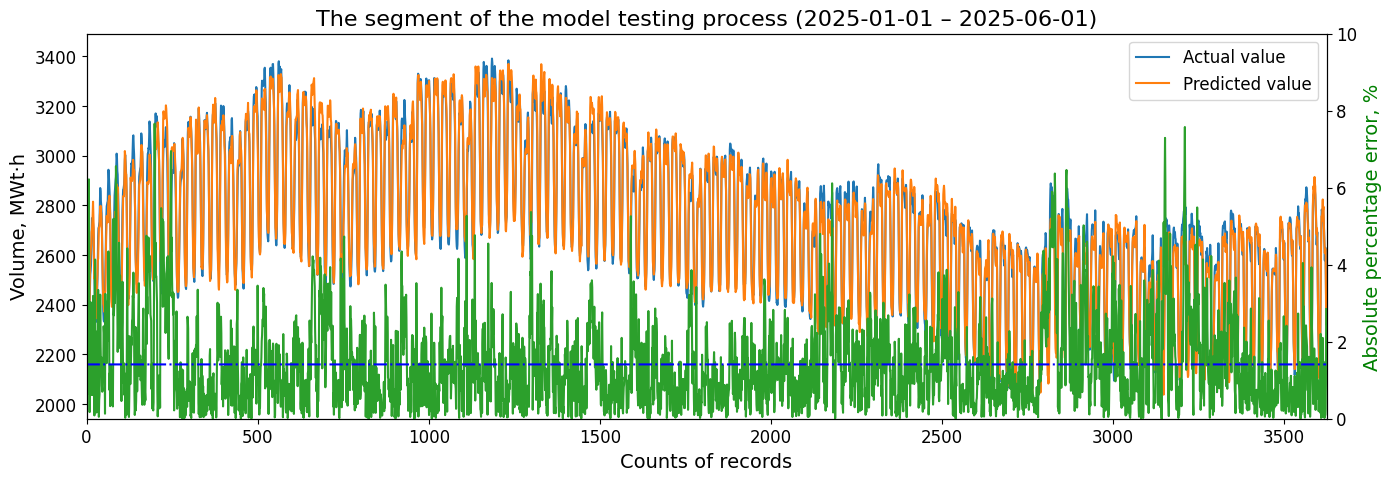

In [4]:
def diff_predict_vs_fact(df_validate_result):
    
    df_validate = df_validate_result.copy()
    
    # добавление новых столбцов (для расчёта усреднённой погрешности)
    df_validate.insert(df_validate.shape[1], 'MAPE', 
                       MAPE(df_validate.Predicted, df_validate.Volume)*100)

    df_validate['Error'] = abs((df_validate.Volume - df_validate.Predicted)*100 / df_validate.Volume)

    df_validate.reset_index(drop=True, inplace=True)

    fig, df_volume = plt.subplots(figsize=(16,5))
    df_error = df_volume.twinx()

    df_volume.plot(df_validate.Volume, label='Actual value')
    df_volume.plot(df_validate.Predicted, label='Predicted value')
    df_error.plot(df_validate.Error, label='Error, %', color='#2ca02c')
    df_error.plot(df_validate.MAPE, '-.b')

    plt.rcParams['font.size'] = '12'

    df_volume.legend(loc='upper right')
    df_volume.set_xlim(0, df_validate.shape[0])
    df_volume.set_ylim(df_validate.Volume.min() - 100, df_validate.Volume.max() + 100)
    df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
    df_volume.set_xlabel('Counts of records', fontsize = 14)

    df_error.set_ylim(0, 10)
    df_error.set_ylabel('Absolute percentage error, %', fontsize = 14, color='g')

    title = 'The segment of the model testing process'
    plt.title(f'{title} ({df_validate.iloc[0].Date.date()} – {df_validate.iloc[-1].Date.date()})', fontsize = 16)
    
    print(f'MAE: {MAE(df_validate.Predicted, df_validate.Volume):.3f} [MW]',
          f'MAPE: {MAPE(df_validate.Predicted, df_validate.Volume):.3%}', sep='\n')

    print(f'\nСреднесуточные потери: {round(df_validate.loss.mean(), 2)} RUR',          
          f'\nМедианные суточные потери: {round(df_validate.loss.median(), 2)} RUR',
          f'\nСуммарные потери за период: [{df_validate.iloc[0].Date.date()} ÷ {df_validate.iloc[-1].Date.date()}]:', 
          f'{round(df_validate.loss.sum(), 2)} RUR', end='\n\n')
    
    df_validate.Month = df_validate.Date.apply(lambda x: f"{x.month_name()} {x.year}")
    list_months = list(df_validate.Month.unique())[:-1]  # исключаем месяц с одним "нулевым" часом

    for month in list_months:
    
        df_month = df_validate[df_validate.Month == month]
    
        print(f'{month}',
              f'MAPE: {MAPE(df_month.Predicted, df_month.Volume):.3%}',
              f'Mean loss: {round(df_month.loss.mean(), 2)} RUR',
              f'Median loss: {round(df_month.loss.median(), 2)} RUR',
              f'Sum loss: {round(df_month.loss.sum(), 2)} RUR', sep='\t')

diff_predict_vs_fact(df_validate_result)